In [100]:
#!/usr/bin/python
from time import time
import pickle
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.impute import IterativeImputer
from pprint import pprint
#from tools.feature_format import feature_format, targetFeatureSplit
#from final_project.tester import dump_classifier_and_data

%matplotlib inline


## Data Exploration
First we'll load the the data into a pandas Dataframe

In [33]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# replace 'Nan' strings with None in dataset
for outer_keys, inner_dicts in data_dict.items():
    for k, v in inner_dicts.items():
        if v == 'NaN':
            data_dict[outer_keys][k] = None
            
df = pd.DataFrame.from_dict(data_dict,
                            orient='index'  # user outer dict keys as column names
                            )
# Handles email_address field
df.fillna(value=pd.np.nan, inplace=True)
print("Rows: {0}\nColumns: {1}".format(*df.shape))  # unpack shape tuple into formatted str

Rows: 146
Columns: 21


Column Names

In [34]:
[print(x) for x in df.columns.to_list()];

salary
to_messages
deferral_payments
total_payments
loan_advances
bonus
email_address
restricted_stock_deferred
deferred_income
total_stock_value
expenses
from_poi_to_this_person
exercised_stock_options
from_messages
other
from_this_person_to_poi
poi
long_term_incentive
shared_receipt_with_poi
restricted_stock
director_fees


In [26]:
df.dropna(thresh=2, inplace=True)
df.shape

(145, 21)

Are there features with missing values?

In [40]:
cm = sns.light_palette("red", as_cmap=True)

nan_percents = (df.isna().sum() / len(df)).sort_values(ascending=False).to_frame().\
    rename(columns={0:"Missing values"}).style.\
    background_gradient(cmap=cm).\
    format("{:.2%}")
nan_percents

,Missing values
loan_advances,97.26%
director_fees,88.36%
restricted_stock_deferred,87.67%
deferral_payments,73.29%
deferred_income,66.44%
long_term_incentive,54.79%
bonus,43.84%
shared_receipt_with_poi,41.10%
to_messages,41.10%
from_this_person_to_poi,41.10%


In [50]:
df.min().sort_values(ascending=False)
# .style.format("{:.0}")


loan_advances                     400000
bonus                              70000
long_term_incentive                69223
director_fees                       3285
exercised_stock_options             3285
salary                               477
total_payments                       148
expenses                             148
to_messages                           57
from_messages                         12
other                                  2
shared_receipt_with_poi                2
from_this_person_to_poi                0
from_poi_to_this_person                0
poi                                False
total_stock_value                 -44093
deferral_payments                -102500
restricted_stock            -2.60449e+06
restricted_stock_deferred   -7.57679e+06
deferred_income             -2.79929e+07
dtype: object

In [9]:
df.salary.describe()

count     146
unique     95
top       NaN
freq       51
Name: salary, dtype: object

Total number of data points

In [10]:
# Total number of data points
print("Observations: {0}\nFeatures: {1}".format(*df.shape))

Observations: 146
Features: 21


Allocation across classes(POI/non-POI)

In [20]:
# Allocation across classes(POI/non-POI)
# df.poi.value_counts()
df['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

In [ ]:
# TODO: add number of features to be used

## Are there features with many missing values?

In [77]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 19 columns):
salary                       94 non-null float64
to_messages                  86 non-null float64
deferral_payments            38 non-null float64
loan_advances                3 non-null float64
bonus                        81 non-null float64
email_address                145 non-null object
restricted_stock_deferred    17 non-null float64
deferred_income              48 non-null float64
expenses                     94 non-null float64
from_poi_to_this_person      86 non-null float64
exercised_stock_options      101 non-null float64
from_messages                86 non-null float64
other                        92 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          145 non-null bool
long_term_incentive          65 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock             109 non-null float64

In [80]:
payments_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                     'loan_advances', 'other', 'expenses', 'director_fees', 'poi']
stock_features = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'poi' ]

email_features = ['to_messages', 'from_poi_to_this_person',
                  'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'poi']

# Finance features in dataset, should be type Int but may resolve to float for compatibility with NaN's
financial_features = ['salary', 'deferral_payments',
                      'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred',
                      'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                      'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
poi_label = ['poi']


In [81]:
pay_df = df[payments_features]
stock_df = df[stock_features]
email_df = df[email_features]


In [95]:
pay_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 10 columns):
salary                 94 non-null float64
bonus                  81 non-null float64
long_term_incentive    65 non-null float64
deferred_income        48 non-null float64
deferral_payments      38 non-null float64
loan_advances          3 non-null float64
other                  92 non-null float64
expenses               94 non-null float64
director_fees          16 non-null float64
poi                    145 non-null bool
dtypes: bool(1), float64(9)
memory usage: 16.5+ KB


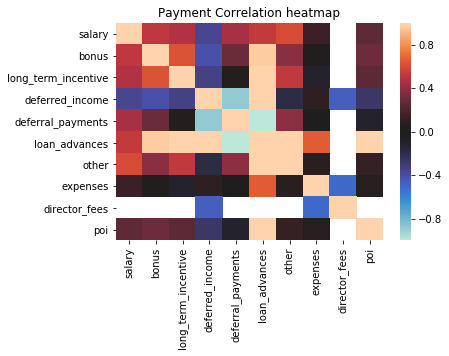

In [94]:
sns.heatmap(pay_df.corr(), center=0)
plt.title("Payment Correlation heatmap");

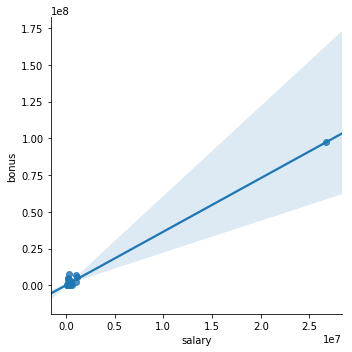

In [48]:
# salary by bonus plot before 'TOTAL' removal
sns.lmplot(x='salary', y='bonus', data=df)
# the 'TOTAL' record
TOTAL = df.sort_values(by=['salary'], ascending=False, na_position='last').head(1)


## Data Exploration

We are working with three effective data sources:
* The CALO Enron Email Dataset
* 
* Enron Statement of financial affairs
    * 
* An Associated Press article from 2005 Listing POI's.  Subcategorized in the article as:
    * Newly Convicted
    * On Trial
    * Awaiting Trial
    * Previously Convicted at Trial
    * Acquitted at Trial
    * Conviction Overturned
    * Guilty Pleas
    * Settlements  


### Issues

* NaN strings affecting column datatype in pandas
    * Handled by setting all 'NaN' strings to None before importing data_dict into pandas
    dataframe
* Email_Address field, upon import, is not useful in ML classification
    * All emails are either: NaN or an email from the 'enron.com' domain.
    * Potentially usable if remapped to a Binary 'Has_email' Feature, based on whether the
    email is present or 'NaN'
* Aggregate Features: Total Payments, Total Stock Value
    * Computed features
* Aggregate Record: TOTAL
    * A record was imported that was the aggregate total for each feature.  This would
    heavily skew data and negatively impact classification accuracy
* Non-person entity record: 'THE TRAVEL AGENCY IN THE PARK'
    * Found to be owned by sister of Enron Chairperson. As we are trying to predict persons
    of interest, this field will be removed since it is a company.
* Person with all NaN Features
    * Record with index "LOWRY CHARLES P" has all nan values for every feature(except poi).
    A google of search of 'enron charles p lowry" is yields little information, thus record
    is being dropped. 
* All POI in the dataset have at least one non-value feature value from both the Financial
and 
* 'Person of Interest' seems somewhat vague.
> "Person of interest" is a term used by U.S. law enforcement when identifying someone involved
in a criminal investigation who has not been arrested or formally accused of a crime. It has no legal
meaning, but refers to someone in whom the police are "interested," either because the person is cooperating
with the investigation, may have information that would assist the investigation, or possesses certain
characteristics that merit further attention.

    * This means we aren't necessarily predicting whether someone is guilty, only if they are
     Case could be made to changed Person of interest from a Binary feature to a 
    categorical one using the statuses from the AP article from 2005.

## Features

There is a large number of NaN values in this dataset.  This is largely due to 

### Email Features
* email_address
    * Many NaN values:  All records with a NaN email address had no emails inside the CALO Enron Email Dataset,
    consequently 
    
    

### Payment Features

* Salary: int
    > Reflects items such as base salary, executive cash allowances, and benefits payments.
* Bonus
    > Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.
* Long Term Incentive: int
    > Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured
against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.
* Deferred Income: int
    > Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors
under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.
* Deferral Payments: int
    > Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.
* Loan Advances: int
    > Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the
promissory notes allow for the option to repay with stock of the company.
* Other
    > Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e.
housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to
employment agreements, as well as imputed income amounts for such things as use of corporate aircraft.
* Expenses
    > Reflects reimbursements of business expenses. May include fees paid for consulting services.
* Director Fees
    >  Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.

### Stock Value Features
> In 1998, 1999 and 2000, Debtor and non-debtor affiliates were charged for options granted. The Black-Scholes method was used to determine the amount to be
charged. Any amounts charged to Debtor and non-debtor affiliates associated with the options exercised related to these three years have not been subtracted
from the share value amounts shown.

* Exercised Stock Options
    > Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through
cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and
the timing of any subsequent sale of the securities.
* Restricted Stock Options
    > Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting
periods, regardless of whether deferred.
* Restricted Stock Deferred
    > Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.


* Want to find outliers in the form of POI but not other outliers
* We know from the mini-projects that the index entry name 'TOTAL' is the wrong kind of outlier that we want
* Manual inspection of index names also revealed the existence of 'THE TRAVEL AGENCY IN THE PARK"
    * Seems to be the travel agency of choice for Enron employees.  Essentially mandatory to use for Enron employees.
    * Not a 'person' and not an Enron employee.  Also many NaN fields including Email Address.  Dropping this col.
* Ropping 

In [83]:
# dropping computed 'TOTAL' observation
df.drop(index='TOTAL', inplace=True)

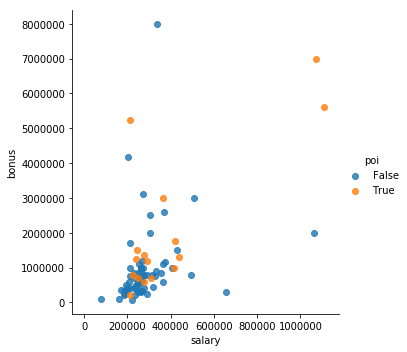

In [55]:
# salary by bonus plot after 'TOTAL' removal
sns.lmplot(x='salary', y='bonus', data=df,
           fit_reg=False, # No regression line
           hue='poi');

In [74]:
#Remove aggregate columns
total_cols = [x for x in df.columns.to_list() if 'total' in x]
df.drop(columns=total_cols, inplace=True)
df.shape




(145, 19)

In [110]:
# New dataframe, dropping any records with nan values
# X = df[['salary','bonus', 'poi']].dropna(how='any')
# y = X.pop('poi')
# y = df['poi']
X = df.copy()
X.drop(['email_address'], axis=1, inplace=True)
y = X.pop('poi')
# X = np.round(imp.transform(X))
# X = imp.transform(X)
X = IterativeImputer(max_iter=10000).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=3), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=3), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))


# clf = GaussianNB()
# 
# t0 = time()
# # Train the classifier
# clf.fit(features_train, labels_train)
# print("Training time:", round(time()-t0, 3), "s")
# 
# t1 = time()
# # Make predictions with our classifier
# pred = clf.predict(features_test)
# print("Prediction time:", round(time()-t1, 3), "s")
# # How accurate are our predictions
# accuracy = accuracy_score(pred, labels_test)
# print(f"Accuracy: {accuracy*100:.2f}%")



Prediction accuracy for the normal test dataset with PCA
81.08%


Prediction accuracy for the standardized test dataset with PCA
81.08%



In [72]:
# sns.boxplot(data=df)


In [73]:
# %%time
# g = sns.PairGrid(df, hue="poi")
# g.map_diag(plt.hist)
# g.map_offdiag(plt.scatter)
# g.add_legend(); # semi-colon to hide unsiqhtly __repl__ call
